In [1]:
import time
import tempfile
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from MITRotor.PressureSolver.poisson_pressure_linear import construct_f
from MITRotor.PressureSolver import Geometry, PressureSolver

# Use Latex Fonts
plt.rcParams.update({"text.usetex": True, "font.family": "serif"})
geometry = Geometry.EquidistantRectGridOdd(40, 40, 0.05, 0.05)

FIGDIR = Path("fig")
FIGDIR.mkdir(parents=True, exist_ok=True)

print(geometry.xmesh.shape)

(800, 800)


In [2]:
# This function plots a 2D field

imshow_params = dict(
    cmap="RdYlBu_r",
    extent=[geometry.x.min(), geometry.x.max(), geometry.y.min(), geometry.y.max()],
)


def plot_field(field, xlim=(-5, 5), ylim=(-2.5, 2.5), title="", **kwargs):
    plt.figure(figsize=(7.5, 3), dpi=150)
    kwargs.update(imshow_params)
    plt.imshow(field.T, **kwargs)

    plt.xlim(*xlim)
    plt.ylim(*ylim)

    plt.title(title)
    plt.xlabel("x [R]")
    plt.ylabel("y [R]")

In [3]:
# This class animates a bunch of saved figures.

import ffmpeg


class Animator:
    def __init__(self):
        self.temp_dir = tempfile.TemporaryDirectory()
        self.index = 0

    def add_frame(self, field, title="", xlim=(-20, 20), ylim=(-5, 5), **kwargs):
        plot_field(field, title=title, xlim=xlim, ylim=ylim, **kwargs)
        plt.savefig(
            Path(self.temp_dir.name) / f"{self.index:03d}.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.close()
        self.index += 1

    def animate(self, out_fn, framerate=10):
        file_list = list(Path(self.temp_dir.name).iterdir())
        print(f"animating {len(file_list)} frames...")
        (
            ffmpeg.input(
                self.temp_dir.name + "/*.png", pattern_type="glob", framerate=framerate
            )
            .output(out_fn.as_posix())
            .run(overwrite_output=True, quiet=True)
        )

    def reset(self):
        self.temp_dir.cleanup()
        self.temp_dir = tempfile.TemporaryDirectory()
        self.index = 0

In [4]:
# This context manager measures the time to execute some code.


class measure_time:
    def __enter__(self):
        self.start = time.perf_counter()
        return self

    def __exit__(self, type, value, traceback):
        self.time = time.perf_counter() - self.start
        self.readout = f"Time: {self.time:.3f} seconds"
        print(self.readout)

# Unified momentum theory a the pressure poisson equation

We begin with the steady-state inviscid Navier-Stokes equations in 2 dimensions:

$$
U\frac{\partial U}{\partial x} + V\frac{\partial U}{\partial y} = -\frac{\partial p}{\partial x} + f_x
$$
$$
U\frac{\partial V}{\partial x} + V\frac{\partial V}{\partial y} = -\frac{\partial p}{\partial y} + f_y
$$
$$
\frac{\partial U}{\partial x} + \frac{\partial V}{\partial y} = 0
$$


where $f_x$ and $f_y$ are the uniform forcing from the actuator line:
$$f_x = \frac{\Delta p}{2}\delta(x)\text{rect}\left(\frac{y}{2}\right)$$
$$ f_y=0$$

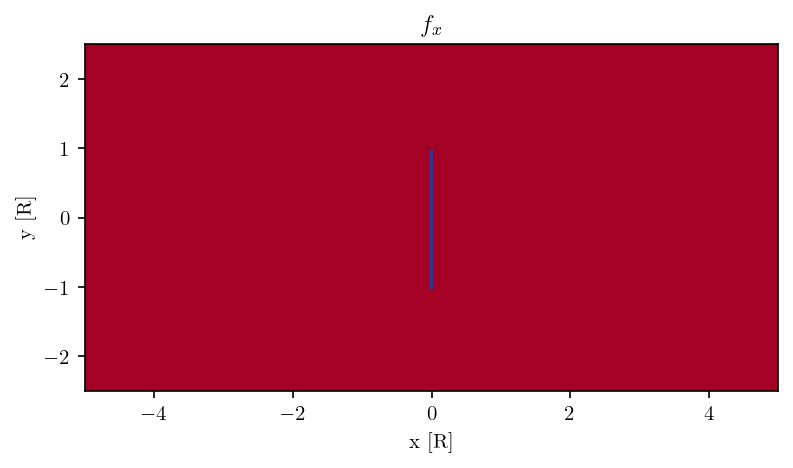

In [5]:
fx, fy = construct_f(0.5, geometry)


plot_field(fx, title="$f_x$")

We can decompose the velocities by a constant base wind speed and a deviation term:
$$ U = 1 + w_x$$
$$V = w_y$$

which gives the PDEs:
$$ \frac{\partial w_x}{\partial x} + \underbrace{w_x\frac{\partial w_x}{\partial x} + w_y\frac{\partial w_x}{\partial y}}_{-g_x} = -\frac{\partial p}{\partial x} + f_x $$

$$
\frac{\partial w_y}{\partial x}+\underbrace{w_x\frac{\partial w_y}{\partial x} + w_y\frac{\partial w_y}{\partial y}}_{-g_y} = -\frac{\partial p}{\partial y} + f_y
$$
$$
\frac{\partial w_x}{\partial x} + \frac{\partial w_y}{\partial y} = 0
$$



We can group the advection terms into their own forcing terms, $g_x$, $g_y$, which are a function of the velocities.


$$
\frac{\partial w_x}{\partial x} = -\frac{\partial p}{\partial x} + f_x +g_x
$$
$$
\frac{\partial w_y}{\partial x} = -\frac{\partial p}{\partial y} + f_y +g_y
$$
Without going into detail, by taking the divergence of these equations and simplifying using the continuity equation, one can arrive at the pressure-Poisson equation:

$$
\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = \left(\frac{\partial f_x}{\partial x} + \frac{\partial f_y}{\partial y}\right) + \left(\frac{\partial g_x}{\partial x} + \frac{\partial g_y}{\partial y}\right)
$$
We can decompose $w_x$, $w_y$, and $p$ into a part caused by $f$, the ***linear*** term, and a part caused by $g$, the ***nonlinear*** term.
$$p = p^f + p^g$$
$$w_x = w_x^f + w_x^g$$
$$w_y = w_y^f + w_y^g$$
which gives two sets of PDE's which can be solved separately.



## Linear pressure and velocity PDE


$$
\frac{\partial w_x^f}{\partial x} = -\frac{\partial p^f}{\partial x} + f_x
$$
$$
\frac{\partial w_y^f}{\partial x} = -\frac{\partial p^f}{\partial y} + f_y
$$
$$
\frac{\partial^2 p^f}{\partial x^2} + \frac{\partial^2 p^f}{\partial y^2} =\frac{\partial f_x}{\partial x} + \frac{\partial f_y}{\partial y}
$$
## Nonlinear pressure and velocity PDE


$$
\frac{\partial w_x^g}{\partial x} = -\frac{\partial p^g}{\partial x} + g_x
$$
$$
\frac{\partial w_y^g}{\partial x} = -\frac{\partial p^g}{\partial y} + g_y
$$
$$
\frac{\partial^2 p^g}{\partial x^2} + \frac{\partial^2 p^g}{\partial y^2} = \frac{\partial g_x}{\partial x} + \frac{\partial g_y}{\partial y}
$$
the third equation in each PDE is the pressure-Poisson equation, which can be solved independently of the other two equations.



# Solving the pressure-Poisson equation
Consider the pressure-Poisson equation relating the pressure to an arbitrary force field, $f_x$, $f_y$.
$$
\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} = \frac{\partial f_x}{\partial x} + \frac{\partial f_y}{\partial y}
$$

### Solution 1: Iterative scheme
We can discretise the PDEs using central differencing. Second derivatives look like:
$$\frac{\partial^2 p}{\partial x^2} \approx \frac{p_{i+1,j} - 2p_{i,j} + p_{i-1,j}}{\Delta x ^2}$$
and first derivatives look like:
$$\frac{\partial f_x}{\partial x} \approx \frac{f_{x, i+1, j} - f_{x, i-1, j}}{2\Delta x}$$


as $f_x$ and $f_y$ are known, we can calculate $\frac{\partial f_x}{\partial x} + \frac{\partial f_y}{\partial y}$ . lets call it $c_{i, j}$.

This gives:
$$\Delta y^2(p_{i-1,j}+p_{i+1,j}) + \Delta x^2(p_{i,j-1}+p_{i,j+1}) - 2(\Delta x^2+\Delta y^2)p_{i,j} = c_{i,j}$$
If $p_{i,j}$ is isolated, a simple iterative scheme is produced:
$$
p_{i,j} =\frac{1}{2(\Delta x^2+\Delta y^2)}\left(c_{i,j} + \Delta y^2(p_{i-1,j}+p_{i+1,j}) + \Delta x^2(p_{i,j-1}+p_{i,j+1})\right)

$$
Iterate until converged. 


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:37<00:00, 102.19it/s]


Time: 97.871 seconds


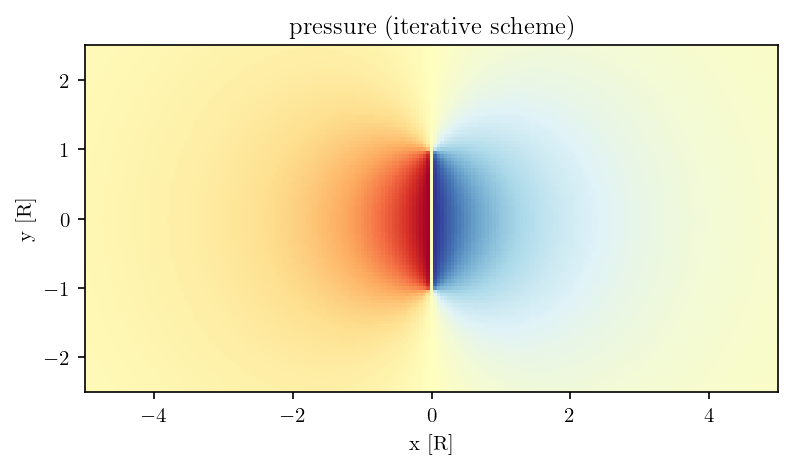

In [6]:
solver = PressureSolver.Iterative(geometry)

with measure_time() as t_iterative:
    sol_iterative = solver.solve(fx, fy, eps=0.000001)

plot_field(sol_iterative.p, title="pressure (iterative scheme)")

### Solution 2: Sparse matrix inversion
The same discretisation from the previous section can be rearranged to have all the pressure terms on the same side.This can then be represented in matrix form.


$$
\underbrace{\begin{bmatrix}
a & b & 0      & c & \cdots & 0 \\
 b & a & b & \ddots & c& \vdots \\
  0     & b & a & b & \ddots & c \\
 c & \ddots & b & a & b & 0 \\
 \vdots & c & \ddots & b & a & b \\
 0      & \cdots & c & 0      & b & a
\end{bmatrix}}_{A}\bf{x}=\bf{c}
$$

This can be solved using a sparse matrix solver (ideally a solver for a sparse banded matrix a.k.a. an "outrigger" matrix).

Time: 14.417 seconds


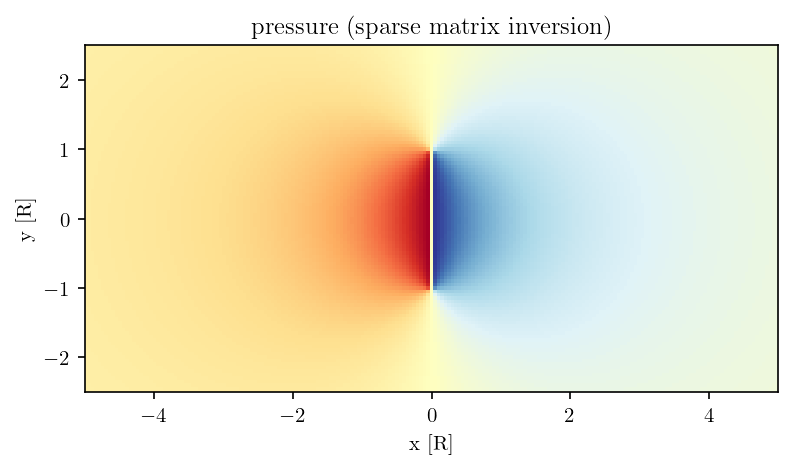

In [7]:
solver = PressureSolver.MatrixInversion(geometry)

with measure_time() as t_matrix:
    sol_matrix = solver.solve(fx, fy)

plot_field(sol_matrix.p, title="pressure (sparse matrix inversion)")

## Another form of the solution
The solution to the Laplacian with impulse forcing at an arbitrary point in space, $(x',y')$:

$$
\frac{\partial^2 G}{\partial x^2} + \frac{\partial^2 G}{\partial y^2} = \delta(x-x',y-y')
$$
has the solution (i.e. the Green's function) of:
$$
G(x,y, x', y') = \frac{1}{2\pi}\log(\sqrt{(x-x')^2 + (y-y')^2})
$$

Differentiating these two expressions gives a new Green-like function solution which better resembles our Pressure-Poisson problem:


$$
\frac{\partial^2 \frac{\partial G}{\partial x}}{\partial x^2} + \frac{\partial^2 \frac{\partial G}{\partial x}}{\partial y^2} = \frac{\partial \delta(x-x',y-y')}{\partial x}
$$
has the solution (i.e. the Green's function) of:
$$
\frac{\partial G}{\partial x}(x, y, x', y') = \frac{1}{2\pi}\frac{x-x'}{(x-x')^2+(y-y')^2}
$$



By superimposing infinite impulses of different amplitudes, any Poisson equation can be solved by integrating over all space:
$$
p(x, y) = \iint_\mathbb{R^2}f_x(x,y)\frac{\partial G}{\partial x}(x, y, x', y')dx'dy'

$$
$$
p(x, y) = \frac{1}{2\pi}\iint_\mathbb{R^2}f_x\frac{x-x'}{(x-x')^2 + (y-y')^2}dx'dy'
$$

The same can be applied for $f_y$ by differentiating by $y$, giving the full solution to the pressure-Poisson equation in 2D cartesian space:
$$
\boxed{p(x, y) = \frac{1}{2\pi}\iint_\mathbb{R^2}\frac{f_x(x-x') + f_y(y-y')}{(x-x')^2 + (y-y')^2}dx'dy'}
$$

Note: I think this only works if the boundary condition is fixed to zero.

### Solution 3: Directly solving the double integral
The above integral can be numerically solved by defining a 4 dimensional grid over $x, y, x', y'$, and integrating over the last two dimensions, $x', y'$. Unfortunately, this method is computationally intractable:

In [8]:
# solver = PressureSolver.GreensFunctionIntegration(geometry)

# with measure_time():
#     solver.solve(fx, fy)

### Solution 4: Convolutions

The previous equation can be written as the sum of two 2D convolutions:

$$
p(x, y) = \frac{1}{2\pi}\left(f_x \circledast \frac{x}{x^2 + y^2} +  f_y \circledast \frac{y}{x^2 + y^2}\right)
$$

where $\circledast$ is the 2D convolution operator:

$$ f \circledast k = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} f(x-x',y-y')k(x',y') dx'dy'$$

Convolutions can be efficiently solved in the frequency domain. We can use Scipy's `signal.fftconvolve()` function to do this automatically.



In [9]:
from IPython.display import Image
from IPython.core.display import HTML

Image(url="https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w03/imgs/sobel1.png")

In [10]:
Image(url="https://www.cs.toronto.edu/~lczhang/aps360_20191/lec/w03/imgs/sobel2.png")

0.01


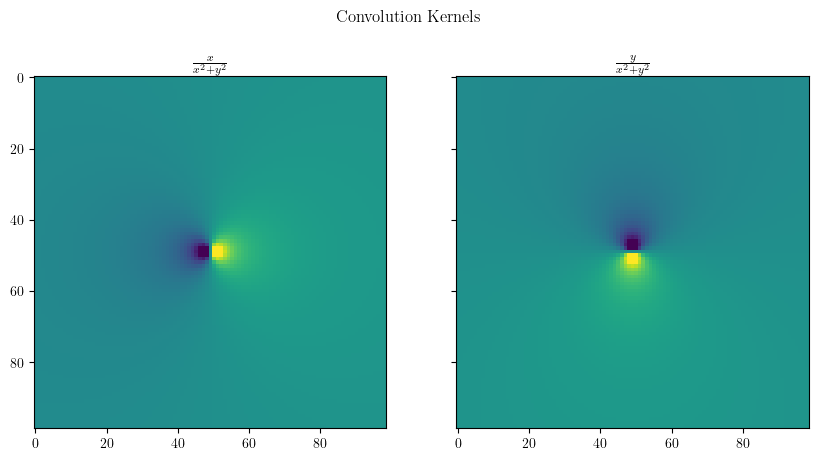

In [11]:
_geometry = Geometry.EquidistantRectGridEven(0.5, 0.5, 0.01, 0.01)
solver = PressureSolver.Convolution(_geometry)

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=[10, 5])
print(solver.x_kernel.max())
axes[0].imshow(solver.x_kernel.T, vmin=-0.003, vmax=0.003)
axes[1].imshow(solver.y_kernel.T, vmin=-0.003, vmax=0.003)


axes[0].set_title(r"$\frac{x}{x^2+ y^2}$")
axes[1].set_title(r"$\frac{y}{x^2+ y^2}$")

plt.suptitle("Convolution Kernels")
plt.show()

Time: 0.384 seconds


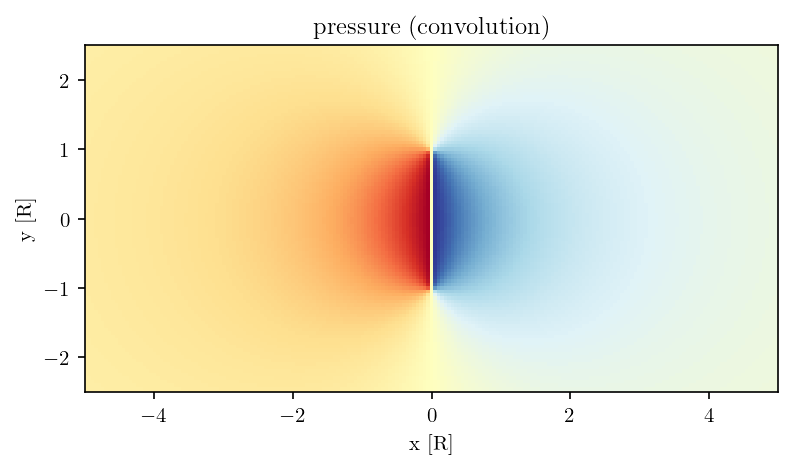

In [12]:
solver = PressureSolver.Convolution(geometry)

with measure_time() as t_convolution:
    sol_conv = solver.solve(fx, fy)

plot_field(sol_conv.p, title="pressure (convolution)")

Text(0.5, 0, 'Solution time [s]')

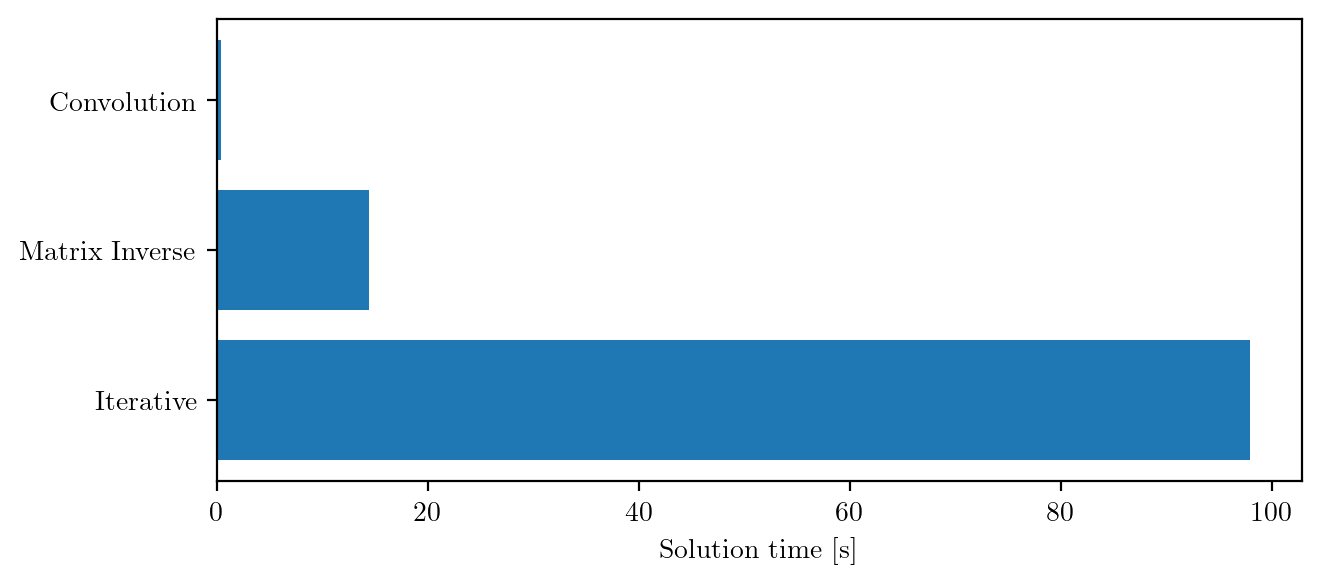

In [13]:
plt.figure(figsize=(7, 3), dpi=200)
plt.barh(
    ["Iterative", "Matrix Inverse", "Convolution"],
    [t_iterative.time, t_matrix.time, t_convolution.time],
)
plt.xlabel("Solution time [s]")

### Analytical solution (to uniform actuator line forcing. ie. the linear term).
i.e. 
$$
p(x, y) = \frac{1}{2\pi}\iint_\mathbb{R^2}\frac{f_x(x-x') + f_y(y-y')}{(x-x')^2 + (y-y')^2}dx'dy'
$$
where
$$ 
f_x = \frac{\Delta p}{2}\delta(x)\text{rect}\left(\frac{y}{2}\right)$$
$$f_y=0$$



$$
p(x, y) = \frac{\Delta p}{4\pi}\lim_{\epsilon \rightarrow 0}\int_{-\epsilon}^\epsilon\delta(x')dx'\int_{-1}^1\text{rect}\left(\frac{y}{2}\right)dy'\int_{-\epsilon}^\epsilon\int_{-1}^1\frac{x-x'}{(x-x')^2 + (y-y')^2}dx'dy'
$$

$$
p(x, y) = \int_{-1}^1\frac{x}{x^2 + (y-y')^2}dy'
$$

Let $y-y' = x\tan\theta$

Then $dy' = x\sec^2\theta ,d\theta$

The limits of integration change to:

When $y'=1, \tan\theta = \frac{1-y}{x}$
When $y'=-1, \tan\theta = \frac{-1-y}{x}$

So the integral becomes:

$$
\begin{align*}
p(x,y) &= \frac{\Delta p}{2\pi}\int_{\arctan\left(\frac{1-y}{x}\right)}^{\arctan\left(\frac{-1-y}{x}\right)} \frac{x}{x^2 + x^2\tan^2\theta} x\sec^2\theta d\theta \
&= \frac{\Delta p}{2\pi}\int_{\arctan\left(\frac{1-y}{x}\right)}^{\arctan\left(\frac{-1-y}{x}\right)} d\theta \
&= [\frac{\Delta p}{2\pi}]_{\arctan\left(\frac{1-y}{x}\right)}^{\arctan\left(\frac{-1-y}{x}\right)} \
&= \boxed{-\frac{\Delta p}{2\pi}\left(\arctan\left(\frac{1+y}{x}\right)+ \arctan\left(\frac{1-y}{x}\right)\right)}
\end{align*}
$$



$w_x$ and $w_y$ also have analytical solutions
$$
\frac{\partial w_x^f}{\partial x} = -\frac{\partial p^f}{\partial x} + f_x \Rightarrow w_x^f = -p^f + \int_{-\infty}^\infty f_x
$$
$$
\boxed{w_x^f = \frac{\Delta p}{2\pi}\left(\arctan\left(\frac{1+y}{x}\right)+ \arctan\left(\frac{1-y}{x}\right)\right) + \underbrace{\Delta p}_{\text{when behind rotor only}}}$$ 
$$
\frac{\partial w_y^f}{\partial x} = -\frac{\partial p^f}{\partial y} + f_y \Rightarrow  w_y^f = \int_{-\infty}^\infty -\frac{\partial p^f}{\partial y} dx
$$
$$
\boxed{w_y^f = \frac{\Delta p}{4\pi}\ln \left(\frac{x^2 + (y+1)^2}{x^2 + (y-1)^2}\right)}
$$ 

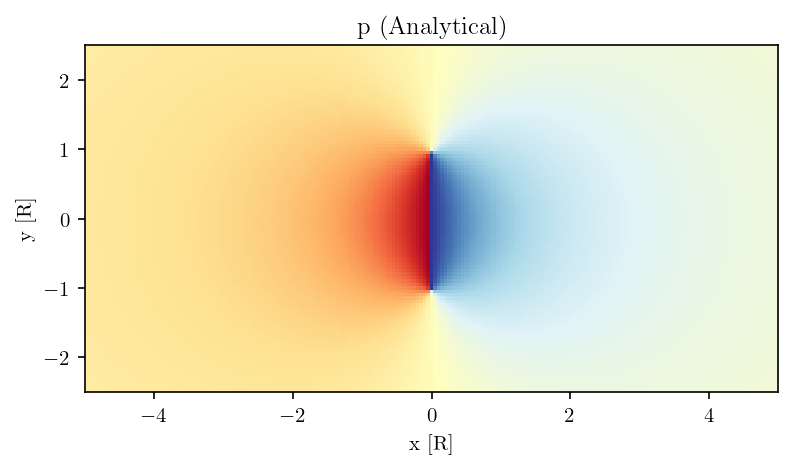

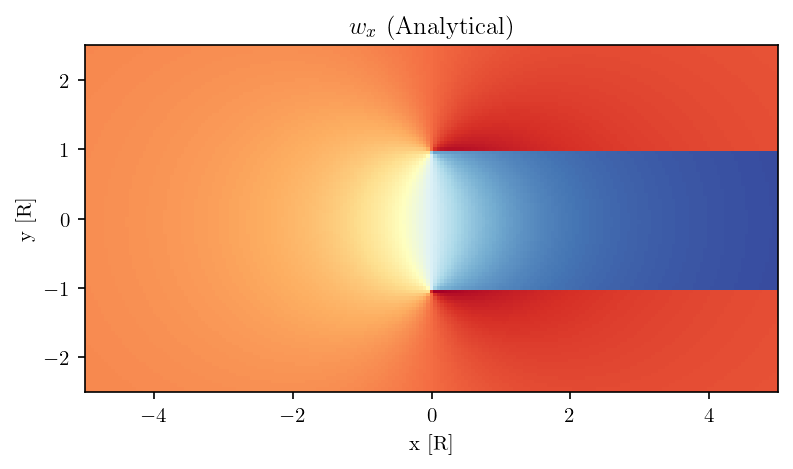

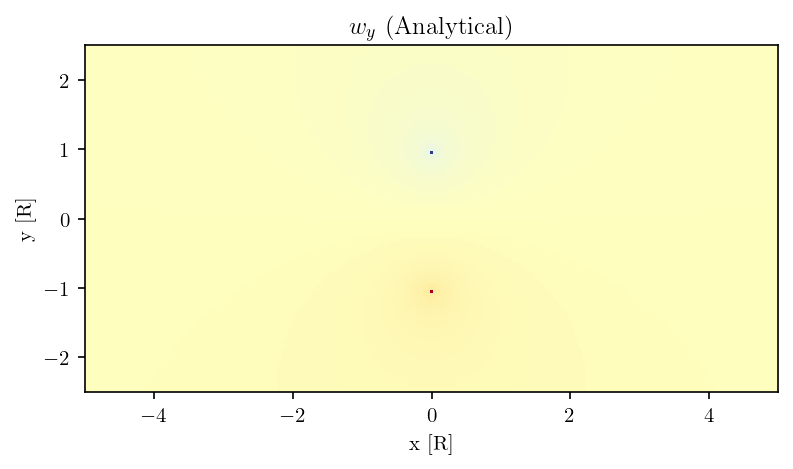

In [14]:
from MITRotor.PressureSolver.poisson_pressure_linear import AnalyticalLinearSolution

sol_analytical = AnalyticalLinearSolution(0.5, geometry)

plot_field(sol_analytical.p, title="p (Analytical)")
plot_field(sol_analytical.wx, title="$w_x$ (Analytical)")
plot_field(sol_analytical.wy, title="$w_y$ (Analytical)")

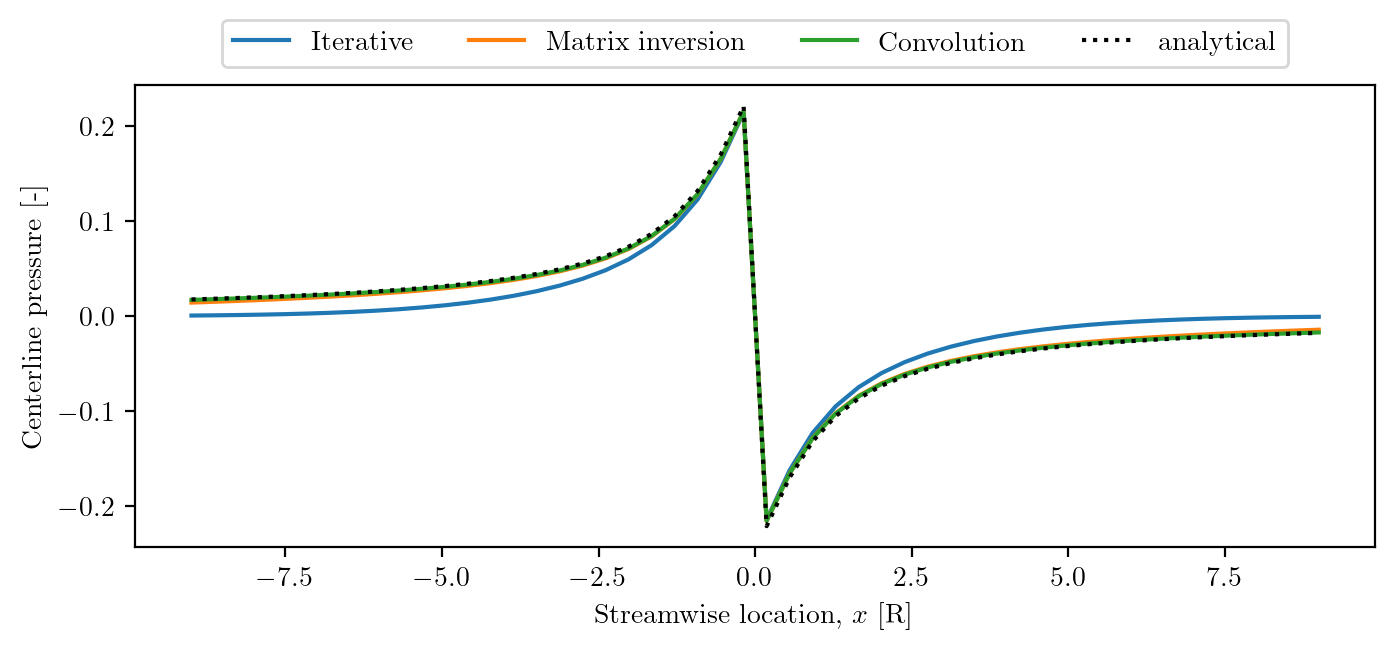

In [15]:
to_plot = {
    "Iterative": sol_iterative,
    "Matrix inversion": sol_matrix,
    "Convolution": sol_conv,
}

x = np.linspace(-9, 9)
plt.figure(figsize=(8, 3), dpi=200)

for label, sol in to_plot.items():
    plt.plot(x, sol.centerline_pressure(x), label=label)
plt.plot(x, sol_analytical.centerline_pressure(x), ":k", label="analytical")

plt.xlabel("Streamwise location, $x$ [R]")
plt.ylabel("Centerline pressure [-]")

plt.legend(ncol=4, loc="lower center", bbox_to_anchor=(0.5, 1.01))

## Solving the *nonlinear* pressure field

So far, we have 1) an efficient method for solving the pressure-Poisson equation using convolutions and 2) an exact solution for the *forcing* pressure field. We have previously ignored the nonlinear pressure field, however, for high thrust rotors, the nonlinear term becomes non-negligible. 

Recall, the field we are solving for is $p_g$, which will require 

$$
\frac{\partial w_x^g}{\partial x} = -\frac{\partial p^g}{\partial x} + g_x
$$
$$
\frac{\partial w_y^g}{\partial x} = -\frac{\partial p^g}{\partial y} + g_y
$$
$$
\frac{\partial^2 p^g}{\partial x^2} + \frac{\partial^2 p^g}{\partial y^2} = \frac{\partial g_x}{\partial x} + \frac{\partial g_y}{\partial y}
$$

where
$$
g_x = -\left(w_x\frac{\partial w_x}{\partial x} + w_y\frac{\partial w_x}{\partial y}\right)
$$

$$
g_y = -\left(w_x\frac{\partial w_y}{\partial x} + w_y\frac{\partial w_y}{\partial y}\right)
$$

and 
$$p = p^f + p^g$$
$$w_x = w_x^f + w_x^g$$
$$w_y = w_y^f + w_y^g$$

## Solution method

- Initialize $g_x$, $g_y$ fields to zero
- begin loop
  - calculate $p^g$ (using pressure-Poisson solver from above)
  - calculate $w_x^g$ and $w_y^g$
  - Calculate $g_x$ and $g_y$
  - Loop until convergence (?)



In [16]:
from MITRotor.PressureSolver.poisson_pressure_nonlinear import NonLinearPoisson

animator = Animator()


def callback(object, iter):
    animator.add_frame(object.p_NL, title=f"$p^g$ (iter: {iter})")


geometry = Geometry.EquidistantRectGridEven(40, 40, 0.1, 0.1)

pde = NonLinearPoisson(geometry, 0.23)
sol, _, _ = pde.solve(max_iter=50, callback=callback)
animator.animate(FIGDIR / "stable.mp4")

animator.reset()
pde = NonLinearPoisson(geometry, 0.25)
sol, _, _ = pde.solve(max_iter=50, callback=callback)
animator.animate(FIGDIR / "unstable.mp4")

animating 18 frames...


/home/jaime/Repositories/MITRotor/MITRotor/PressureSolver/poisson_pressure_nonlinear.py:51: RuntimeWarning: overflow encountered in multiply
  _gx = -self.wx * self.dwxdx - self.wy * self.dwxdy
/home/jaime/Repositories/MITRotor/MITRotor/PressureSolver/poisson_pressure_nonlinear.py:51: RuntimeWarning: invalid value encountered in subtract
  _gx = -self.wx * self.dwxdx - self.wy * self.dwxdy
/home/jaime/Repositories/MITRotor/MITRotor/PressureSolver/poisson_pressure_nonlinear.py:52: RuntimeWarning: overflow encountered in multiply
  _gy = -self.wx * self.dwydx - self.wy * self.dwydy
/home/jaime/Repositories/MITRotor/MITRotor/PressureSolver/poisson_pressure_nonlinear.py:52: RuntimeWarning: invalid value encountered in subtract
  _gy = -self.wx * self.dwydx - self.wy * self.dwydy


animating 23 frames...


### $\Delta p = 0.23 (stable)$
Intrinsic pressure field converges for low thrust values.

In [17]:
from IPython.display import Video

Video(FIGDIR / "stable.mp4")

### $\Delta p = 0.25 (unstable)$
We need are looking for pressure fields up to $\Delta p = 1$ ($C_T=2$), however, the solution fails to converge at around $\Delta p = 0.25$.

In [18]:
Video(FIGDIR / "unstable.mp4")

# Overcoming poor convergence
After MUCH trial and error, we have come to the following method to overcome poor convergence.
- Reduce the resolution significantly (~2 points over the rotor. This slows instability)
- Use an even grid (i.e. rotor is located *between* grid points, not *on* the grid points.)
- Only run a few iterations (~4).

### Centerline pressure at fixed $dp$ versus number of iterations

Text(0, 0.5, '$p^g$')

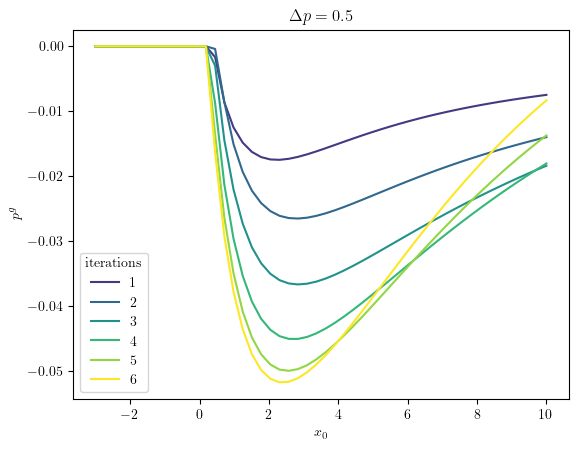

In [35]:
from MITRotor.PressureSolver.ADPressureField import NonlinearADPressureField


dP = 0.5
MAX_ITER = 6

x = np.linspace(-3, 10)
solutions = {}
for max_iter in range(1, MAX_ITER + 1):
    solver = NonlinearADPressureField(iterations=max_iter)
    solutions[max_iter] = solver.get_pressure(dP, x)

plt.figure()
plt.title(f"$\Delta p={dP}$")
for iter, sol in solutions.items():
    plt.plot(x, sol, c=plt.cm.viridis(iter / MAX_ITER), label=f"{iter}")
plt.legend(title="iterations")

plt.xlabel("$x_0$")
plt.ylabel("$p^g$")

## nonlinear pressure versus $x_0$ and $\Delta p$ for varying iterations

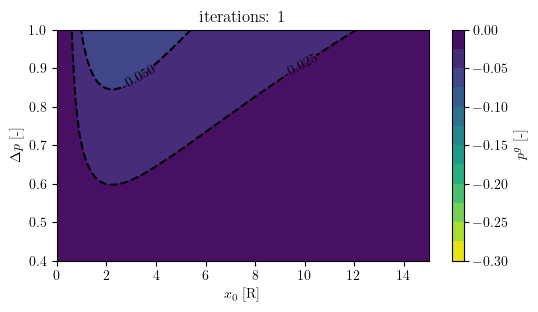

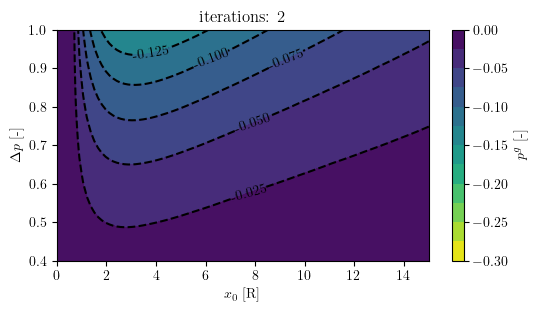

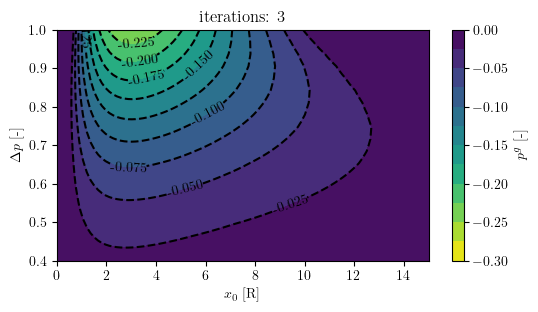

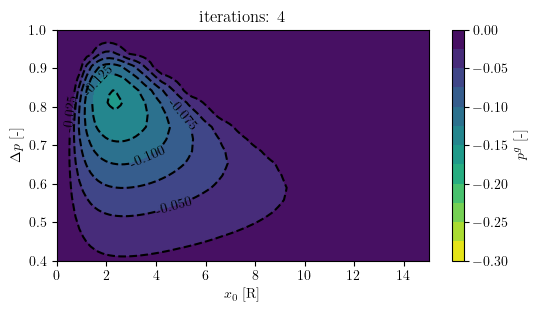

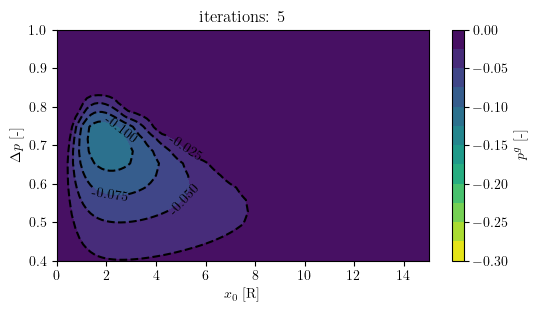

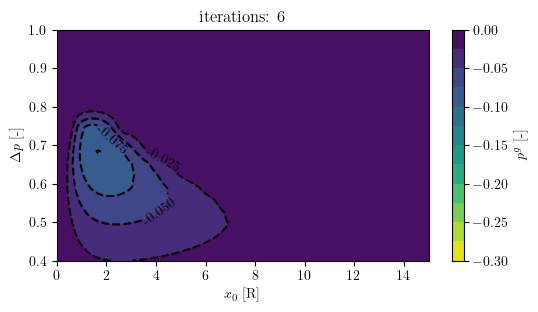

In [20]:
dps = np.linspace(0.4, 1, 20)
xs = np.linspace(0, 15, 100)

for max_iter in [1, 2, 3, 4, 5, 6]:
    solver = NonlinearADPressureField(dx=0.1, iterations=max_iter)

    dp_mesh, x_mesh = np.meshgrid(dps, xs, indexing="ij")
    ps_interp = solver.get_pressure(dp_mesh, x_mesh)
    levels = np.arange(-0.3, 0.001, 0.025)

    plt.figure(figsize=(6, 3))
    CF = plt.contourf(xs, dps, ps_interp, levels=levels, cmap="viridis_r")
    CS = plt.contour(xs, dps, ps_interp, levels=levels, colors="k")
    plt.clabel(CS, inline=True, fontsize=10, fmt="%1.3f")

    cbar = plt.colorbar(CF)
    cbar.set_label(label="$p^g$ [-]")

    plt.title(f"iterations: {max_iter}")
    plt.xlabel("$x_0$ [R]")
    plt.ylabel("$\Delta p$ [-]")

## nonlinear pressure versus $x_0$ and $\Delta p$ for varying $\Delta x$

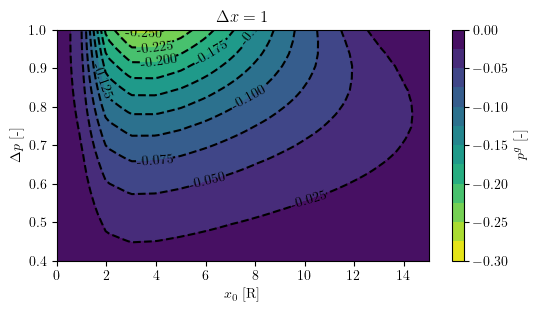

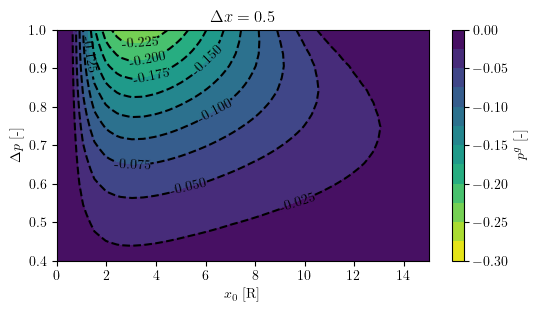

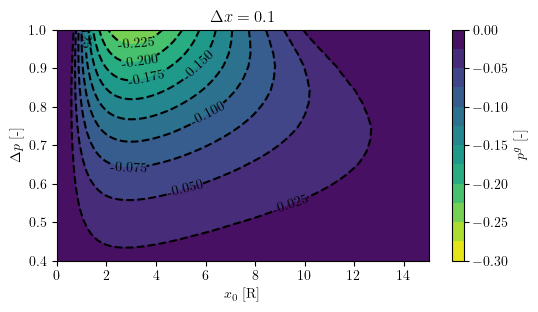

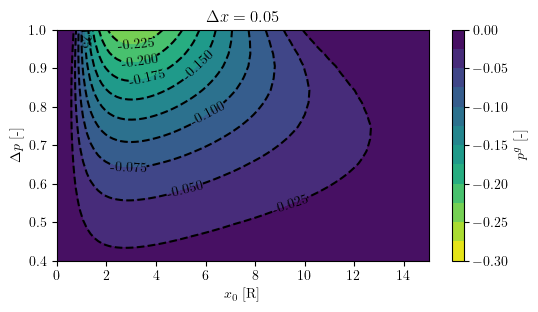

In [34]:
dps = np.linspace(0.4, 1, 20)
xs = np.linspace(0, 15, 100)

for dx in [1, 0.5, 0.1, 0.05]:
    solver = NonlinearADPressureField(dx=dx, iterations=3)

    dp_mesh, x_mesh = np.meshgrid(dps, xs, indexing="ij")
    ps_interp = solver.get_pressure(dp_mesh, x_mesh)
    levels = np.arange(-0.3, 0.001, 0.025)

    plt.figure(figsize=(6, 3))
    CF = plt.contourf(xs, dps, ps_interp, levels=levels, cmap="viridis_r")
    CS = plt.contour(xs, dps, ps_interp, levels=levels, colors="k")
    plt.clabel(CS, inline=True, fontsize=10, fmt="%1.3f")

    cbar = plt.colorbar(CF)
    cbar.set_label(label="$p^g$ [-]")

    plt.title(f"$\Delta x = {dx}$")
    plt.xlabel("$x_0$ [R]")
    plt.ylabel("$\Delta p$ [-]")

# Integrating this pressure model into the Unified Momentum Equations
The unified momentum equations, with the additional nonlinear pressure term are:

$$
\begin{align}

a_n &= 1 - \sqrt{\frac{u_\infty^2 - u_4^2 - v_4^2}{C_T^\prime \cos^2(\gamma) u_\infty^2}-\frac{(p_4 - p_1)}{\frac{1}{2} \rho C_T^\prime \cos^2(\gamma) u_\infty^2}}\\ 
u_4 &= -\frac{1}{4} C_T^\prime (1-a_n) \cos^2(\gamma)u_\infty + \frac{u_\infty}{2} + \frac{1}{2}\sqrt{\left(\frac{1}{2} C_T^\prime (1-a_n) \cos^2(\gamma)u_\infty - u_\infty \right)^2 - \frac{4(p_4 - p_1)}{\rho}}\\ 
v_4 &= -\frac{1}{4} C_T^\prime (1-a_n)^2 \sin(\gamma) \cos^2(\gamma) u_\infty\\ 
p_4 - p_1 &= -\frac{1}{2\pi} \rho C_T^\prime (1-a_n)^2 \cos^2(\gamma) u_\infty^2 \tan^{-1}\left[\underbrace{\frac{2\beta}{\cos(\gamma)}\cfrac{|u_\infty - u_4|}{u_\infty + u_4}\sqrt{\frac{u_\infty + u_4}{(1-a_n)\cos(\gamma)u_\infty}}}_{x_0}\right] + \textcolor{red}{p^g}
\end{align}

$$

When is $p_g$ is a function of the nearwake distance, $x_0$ as well as the thrust level. When is $p_g$ nonzero?

In [31]:
from typing import List
from scipy.io import loadmat
from MITRotor import MomentumTheory


ITERS = 5
DX = 0.1

LES_data_fn = f"LES_streamtube_data.mat"


models_to_compare = {
    "linear": MomentumTheory.UnifiedMomentum(
        nonlinear_pressure_kwargs=dict(iterations=0)
    ),
    "nonlinear": MomentumTheory.UnifiedMomentum(
        nonlinear_pressure_kwargs=dict(iterations=ITERS, dx=DX)
    ),
}
Ctprimes = np.concatenate(
    [np.linspace(0, 12, 100), np.linspace(12, 4000, 200), [100000]]
)

plot_kwargs = {
    "LES_ctp": dict(ls="", marker=".", c="k", label="LES ($C_T'$ input)"),
    "LES_ct": dict(ls="", marker="x", c="k", label="LES ($C_T$ input)"),
    "linear": dict(label="Unified model (linear)"),
    "nonlinear": dict(label="Unified model (nonlinear)"),
    "nonlinear_variation": dict(label="nonlinear (variation)"),
}


def load_LES_data_ctp(filename: Path) -> List[MomentumTheory.MomentumSolution]:
    data = loadmat(filename)

    out = []
    for Cp, Ct, Ctp, p4, a, u4 in zip(
        data["Cp_ctp_input"][0],
        data["Ct_ctp_input"][0],
        data["Ctp_vector"][0],
        data["P4_ctp_input"][0],
        data["a_ctp_input"][0],
        data["u4_ctp_input"][0],
    ):
        out.append(MomentumTheory.MomentumSolution(Ctp, 0, a, u4, 0, p4))

    return out


def load_LES_data_ct(filename: Path) -> List[MomentumTheory.MomentumSolution]:
    data = loadmat(filename)
    out = []
    for Cp, Ct, p4, a, u4 in zip(
        data["Cp_ct_input"][0],
        data["Ct_ct_input"][0],
        data["P4_ct_input"][0],
        data["a_ct_input"][0],
        data["u4_ct_input"][0],
    ):
        Ctp = Ct / (1 - a) ** 2
        out.append(MomentumTheory.MomentumSolution(Ctp, 0, a, u4, 0, p4, 0, 0, True, 0))
    return out


# Load LES
results = {
    "LES_ctp": load_LES_data_ctp(LES_data_fn),
    "LES_ct": load_LES_data_ct(LES_data_fn),
}

# Run unified model and variations
for name, model in models_to_compare.items():
    results[name] = []
    for Ctprime in tqdm(Ctprimes):
        results[name].append(model.solve(Ctprime, 0))

100%|██████████| 301/301 [00:00<00:00, 413.27it/s]


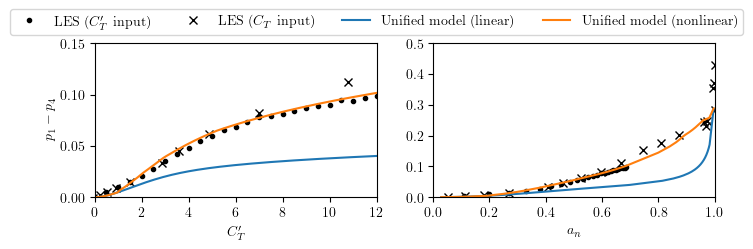

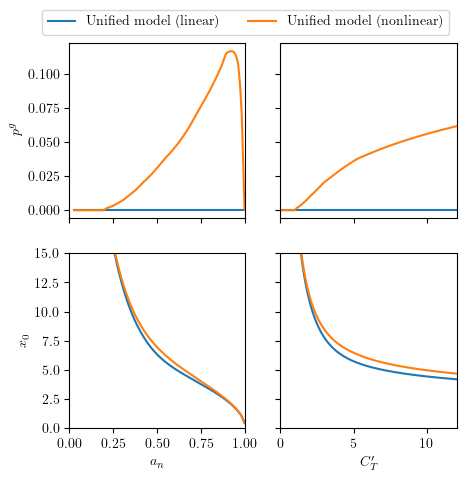

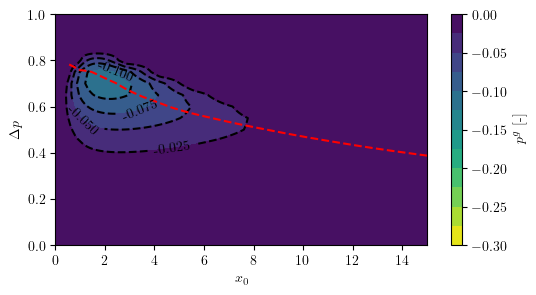

In [32]:
# Plots like Mike's
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(8, 2))
for name, sol_list in results.items():
    p = [-sol.dp for sol in sol_list]
    a = [sol.an for sol in sol_list]
    Ctprime = [sol.Ctprime for sol in sol_list]

    axes[0].plot(Ctprime, p, **plot_kwargs[name])
    axes[1].plot(a, p, **plot_kwargs[name])

axes[0].set_xlabel("$C_T'$")
axes[1].set_xlabel("$a_n$")
axes[0].set_ylabel("$p_1-p_4$")

axes[0].set_ylim(0, 0.15)
axes[1].set_ylim(0, 0.5)
axes[0].set_xlim(0, 12)
axes[1].set_xlim(0, 1)

axes[0].legend(ncol=len(results), loc="lower center", bbox_to_anchor=(1, 1.01))

plt.savefig(
    FIGDIR / f"example_008_modified_unified_iter{ITERS}.png",
    dpi=300,
    bbox_inches="tight",
)

# Plot x0, p_g
fig, axes = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(5, 5))
for name, sol_list in results.items():
    if name in ["LES_ctp", "LES_ct"]:
        continue
    p_g = [-sol.dp_NL for sol in sol_list]
    x0 = [sol.x0 for sol in sol_list]

    Ctprime = [sol.Ctprime for sol in sol_list]
    an = [sol.an for sol in sol_list]

    axes[0, 0].plot(an, p_g, **plot_kwargs[name])
    axes[1, 0].plot(an, x0, **plot_kwargs[name])

    axes[0, 1].plot(Ctprime, p_g, **plot_kwargs[name])
    axes[1, 1].plot(Ctprime, x0, **plot_kwargs[name])

    # axes[1].plot(a, p, **plot_kwargs[name])

axes[0, 0].set_xlim(0, 1)
axes[1, 1].set_xlim(0, 12)
axes[1, 1].set_ylim(0, 15)

axes[0, 0].set_ylabel("$p^g$")
axes[1, 0].set_ylabel("$x_0$")
axes[1, 0].set_xlabel("$a_n$")
axes[1, 1].set_xlabel("$C_T'$")

axes[0, 0].legend(ncol=len(results), loc="lower center", bbox_to_anchor=(1, 1.01))

plt.savefig(
    FIGDIR / f"example_008_modified_unified_x0_iter{ITERS}.png",
    dpi=300,
    bbox_inches="tight",
)

plt.figure(figsize=(6, 3))
sol_list = results["nonlinear"]
dp_grid, x0_grid = models_to_compare["nonlinear"].nonlinear_pressure.interpolator.grid
p_g_vals = models_to_compare["nonlinear"].nonlinear_pressure.interpolator.values

levels = np.arange(-0.3, 0.001, 0.025)

CF = plt.contourf(x0_grid, dp_grid, p_g_vals, levels=levels, cmap="viridis_r")
CS = plt.contour(x0_grid, dp_grid, p_g_vals, levels=levels, colors="k")
plt.clabel(CS, inline=True, fontsize=10, fmt="%1.3f")

cbar = plt.colorbar(CF)
cbar.set_label(label="$p^g$ [-]")

dp = [sol.Ct / 2 for sol in sol_list]
x0 = [sol.x0 for sol in sol_list]

plt.plot(x0, dp, "r--")

plt.xlabel("$x_0$")
plt.ylabel("$\Delta p$")

plt.xlim(0, 15)

plt.savefig(
    FIGDIR / f"example_008_modified_unified_x0_vs_pg_iter{ITERS}.png",
    dpi=300,
    bbox_inches="tight",
)

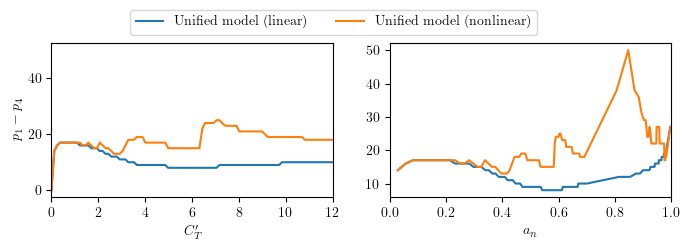

In [24]:
# number of iterations
fig, axes = plt.subplots(1, 2, sharey=False, figsize=(8, 2))
for name, sol_list in results.items():
    if "LES" in name:
        continue
    niter = [sol.niter for sol in sol_list]
    a = [sol.an for sol in sol_list]
    Ctprime = [sol.Ctprime for sol in sol_list]

    axes[0].plot(Ctprime, niter, **plot_kwargs[name])
    axes[1].plot(a, niter, **plot_kwargs[name])

axes[0].set_xlabel("$C_T'$")
axes[1].set_xlabel("$a_n$")
axes[0].set_ylabel("$p_1-p_4$")

# axes[0].set_ylim(0, 0.15)
# axes[1].set_ylim(0, 0.5)
axes[0].set_xlim(0, 12)
axes[1].set_xlim(0, 1)

axes[0].legend(ncol=len(results), loc="lower center", bbox_to_anchor=(1, 1.01))

$p_g$ should ideally be negative always. Perhaps I can clip the values above 0?

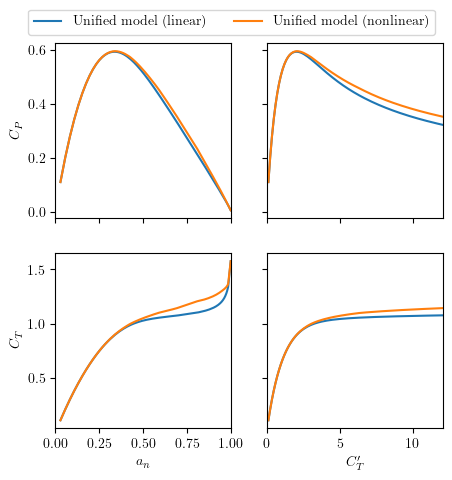

In [27]:
# Plot Cp, CT
fig, axes = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(5, 5))
for name, sol_list in results.items():
    if name in ["LES_ctp", "LES_ct"]:
        continue
    Cp = [sol.Cp for sol in sol_list]
    Ct = [sol.Ct for sol in sol_list]

    Ctprime = [sol.Ctprime for sol in sol_list]
    an = [sol.an for sol in sol_list]

    axes[0, 0].plot(an, Cp, **plot_kwargs[name])
    axes[1, 0].plot(an, Ct, **plot_kwargs[name])

    axes[0, 1].plot(Ctprime, Cp, **plot_kwargs[name])
    axes[1, 1].plot(Ctprime, Ct, **plot_kwargs[name])

    # axes[1].plot(a, p, **plot_kwargs[name])

axes[0, 0].set_xlim(0, 1)
axes[1, 1].set_xlim(0, 12)
# axes[1, 1].set_ylim(0, 15)

axes[0, 0].set_ylabel("$C_P$")
axes[1, 0].set_ylabel("$C_T$")
axes[1, 0].set_xlabel("$a_n$")
axes[1, 1].set_xlabel("$C_T'$")

axes[0, 0].legend(ncol=len(results), loc="lower center", bbox_to_anchor=(1, 1.01))

plt.savefig(
    FIGDIR / f"example_008_modified_unified_x0_iter{ITERS}.png",
    dpi=300,
    bbox_inches="tight",
)

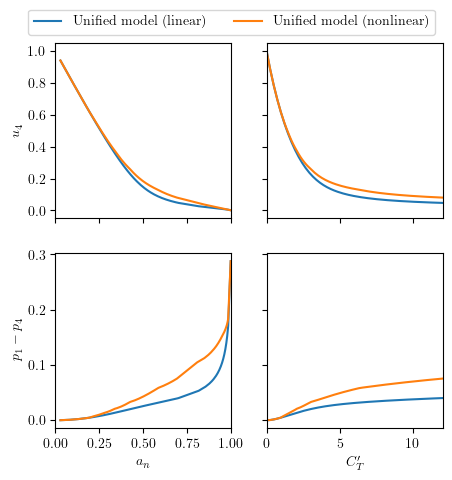

In [28]:
# Plot u4, p1-p4
fig, axes = plt.subplots(2, 2, sharex="col", sharey="row", figsize=(5, 5))
for name, sol_list in results.items():
    if name in ["LES_ctp", "LES_ct"]:
        continue
    u4 = [sol.u4 for sol in sol_list]
    dp = [-sol.dp for sol in sol_list]

    Ctprime = [sol.Ctprime for sol in sol_list]
    an = [sol.an for sol in sol_list]

    axes[0, 0].plot(an, u4, **plot_kwargs[name])
    axes[1, 0].plot(an, dp, **plot_kwargs[name])

    axes[0, 1].plot(Ctprime, u4, **plot_kwargs[name])
    axes[1, 1].plot(Ctprime, dp, **plot_kwargs[name])

    # axes[1].plot(a, p, **plot_kwargs[name])

axes[0, 0].set_xlim(0, 1)
axes[1, 1].set_xlim(0, 12)
# axes[1, 1].set_ylim(0, 15)

axes[0, 0].set_ylabel("$u_4$")
axes[1, 0].set_ylabel("$p_1-p_4$")
axes[1, 0].set_xlabel("$a_n$")
axes[1, 1].set_xlabel("$C_T'$")

axes[0, 0].legend(ncol=len(results), loc="lower center", bbox_to_anchor=(1, 1.01))

plt.savefig(
    FIGDIR / f"example_008_modified_unified_x0_iter{ITERS}.png",
    dpi=300,
    bbox_inches="tight",
)

# Future work
- Fully integrate $p_g$ into unified momentum equation solver
- Compare with LES.
- Publish paper